In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.compose import make_column_selector, make_column_transformer

In [3]:
heart_raw = pd.read_csv('heart.csv')
heart_raw

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Heart Disease Dataset
## 1. EDA and Preprocessing
### 1.1 Dataset Preparation

---
### **Description**


> \# marks the categorical data

- Age: age of the patient [years]
- #Sex: sex of the patient [M: Male, F: Female]
- #ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- #FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- #RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation     or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- #ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- #ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- #HeartDisease: output class [1: heart disease, 0: Normal]

---
**Problem 1** 

No duplicated row found in this data

There is no null datas as well.

But should treat #FastingBS and #HeartDisease as categorical than numeric.


In [4]:
heart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
heart_raw[heart_raw.duplicated(keep='first')]
heart_raw_dropped = heart_raw.drop_duplicates()
heart_raw_dropped = heart_raw_dropped.astype({'FastingBS':'category','HeartDisease':'category'})

heart_raw_dropped

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


**Problem 2**

Drop Missing Values

Cholesterl will be done later.

One missing value found in RestingBP.

In [6]:
heart_raw_dropped = heart_raw_dropped.drop(heart_raw_dropped[heart_raw_dropped['RestingBP'] == 0].index)

### 1.2 Train Test Split

Get test test out of sight first.


However, male's portion in the data is dominent significantly. Considering about the already known difference of morbidity in different sex, we can do stratified sampling when spliting the test and train sets.

***For ease of plotting, onehot encode for categorical datas will be done after EDA part.***

---

In [7]:
predictor = heart_raw_dropped[heart_raw_dropped.columns.drop('HeartDisease')]
target = heart_raw_dropped['HeartDisease']

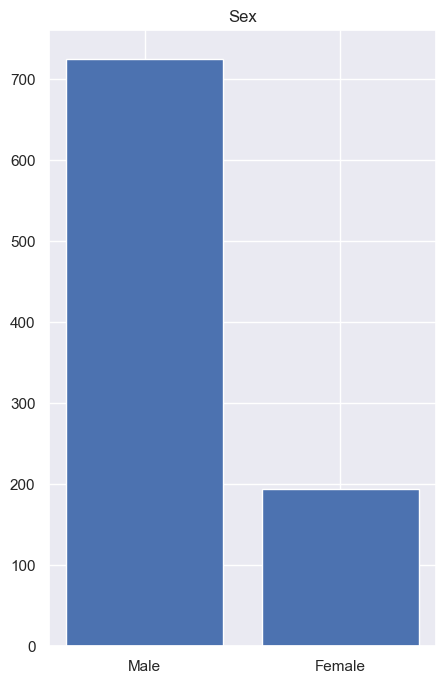

In [8]:
cat = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
numeric = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

plt.figure(figsize=(5, 8))
sex = pd.DataFrame(predictor['Sex'].astype('category'))
plt.title('Sex')
sexc = sex.value_counts()
plt.bar(list(['Male','Female']),sexc.tolist())

plt.show()

In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(predictor,target,test_size=0.2,stratify=predictor['Sex'])

Check if it is correctly splited by sex:

In [10]:
print("Ratios:")
(Xtrain['Sex'].value_counts().iloc[1] / Xtrain['Sex'].value_counts().iloc[0] , predictor['Sex'].value_counts().iloc[1] / predictor['Sex'].value_counts().iloc[0])

Ratios:


(0.2659758203799655, 0.26657458563535913)

In [11]:
print("Ratios:")
(Xtest['Sex'].value_counts().iloc[1] / Xtest['Sex'].value_counts().iloc[0] , predictor['Sex'].value_counts().iloc[1] / predictor['Sex'].value_counts().iloc[0])

Ratios:


(0.2689655172413793, 0.26657458563535913)

### 1.3 EDA

---

Overall correlation check by heatmap

C:\Users\Elijah\AppData\Local\Temp\ipykernel_8568\4057630460.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(encoded_raw.corr(),annot=True,cmap='YlGnBu',fmt='.2f',linewidths=2)


<Axes: >

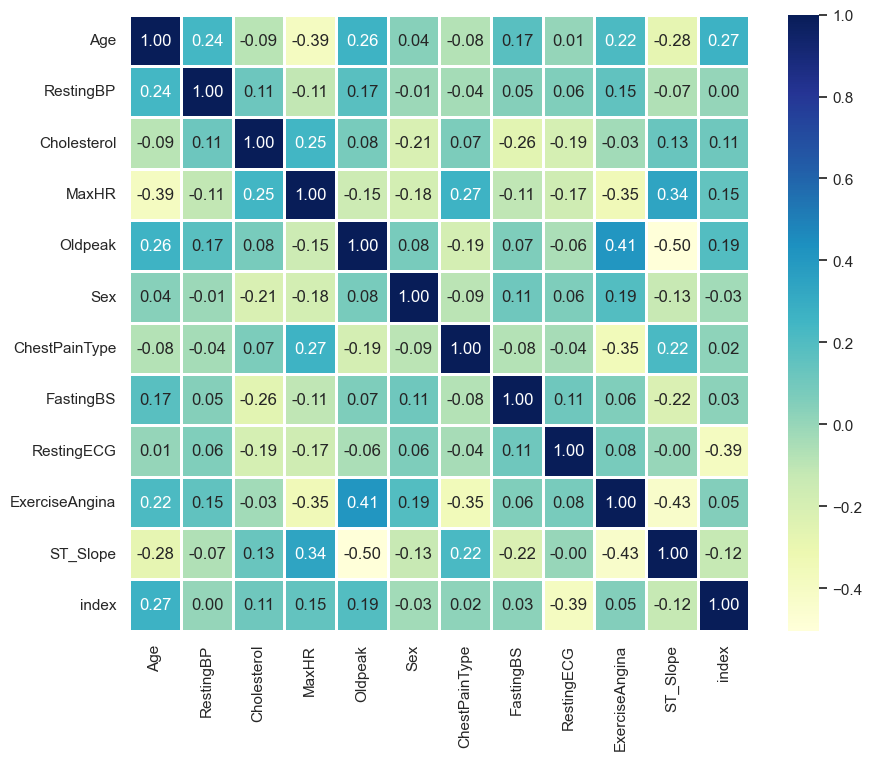

In [12]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
TrainData.columns.tolist()

ordinalEncoder = OrdinalEncoder()
TrainData2 = TrainData.reset_index()
cat_encode = pd.DataFrame(ordinalEncoder.fit_transform(TrainData2[cat]))
cat_encode.columns = ordinalEncoder.get_feature_names_out()
cat_encode
encoded_raw = pd.concat([TrainData2[numeric],cat_encode,Ytrain.reset_index()],axis=1)

plt.figure(figsize=(10,8))
sb.heatmap(encoded_raw.corr(),annot=True,cmap='YlGnBu',fmt='.2f',linewidths=2)

**`Age`, `Oldpeak`, `MaxHR`, `ChestPainType`, `ExerciseAngina`, `ST_Slope` have great influence on result**

**`RestingBP`, `RestingECG` can be ignored.**

#### 1.3.1 Show relationship between Response and Categorical predictors

In [13]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
TrainData.columns.tolist()

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

A quick overview for all variables:

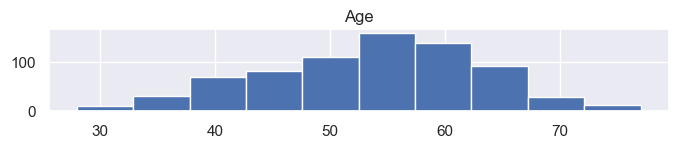

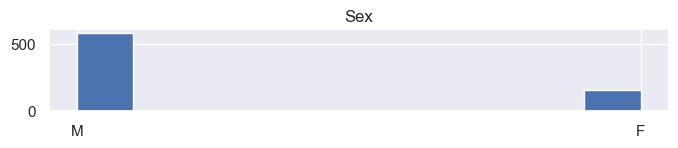

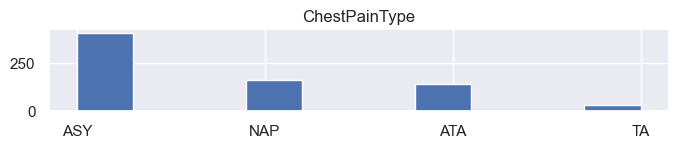

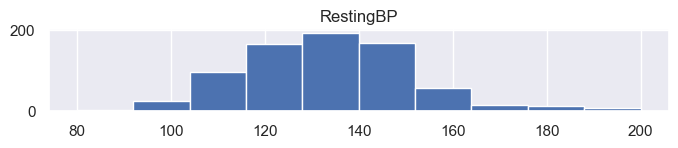

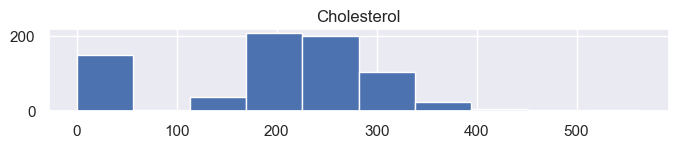

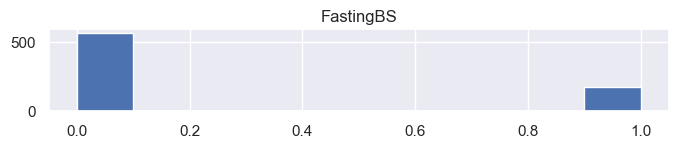

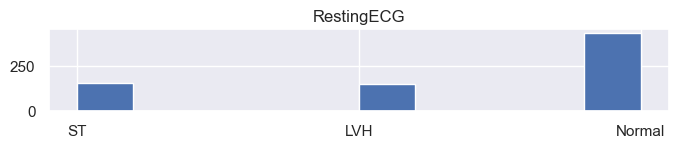

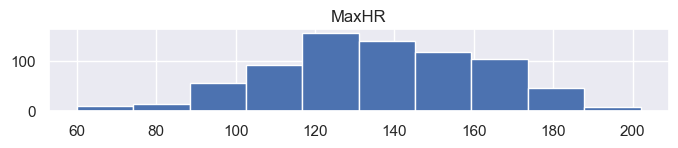

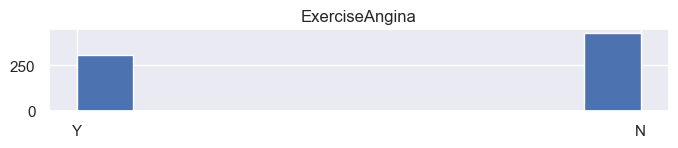

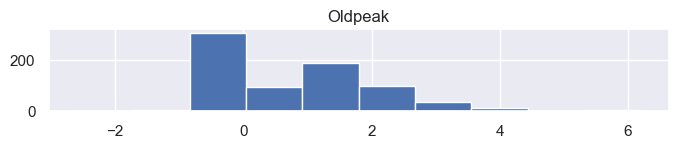

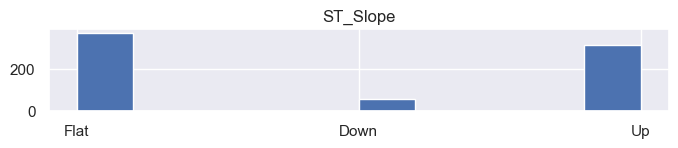

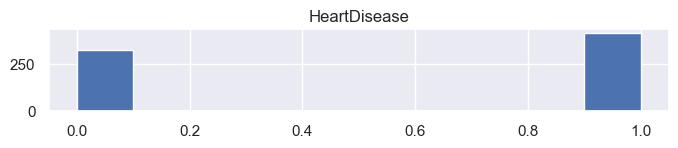

In [14]:
lis = TrainData.columns.tolist()
l =  len(lis)
for v in range(l):
    plt.figure(figsize=(8, 15))
    plt.subplot(l,1,v+1)
    plt.title(lis[v])
    plt.hist(TrainData[lis[v]])
    

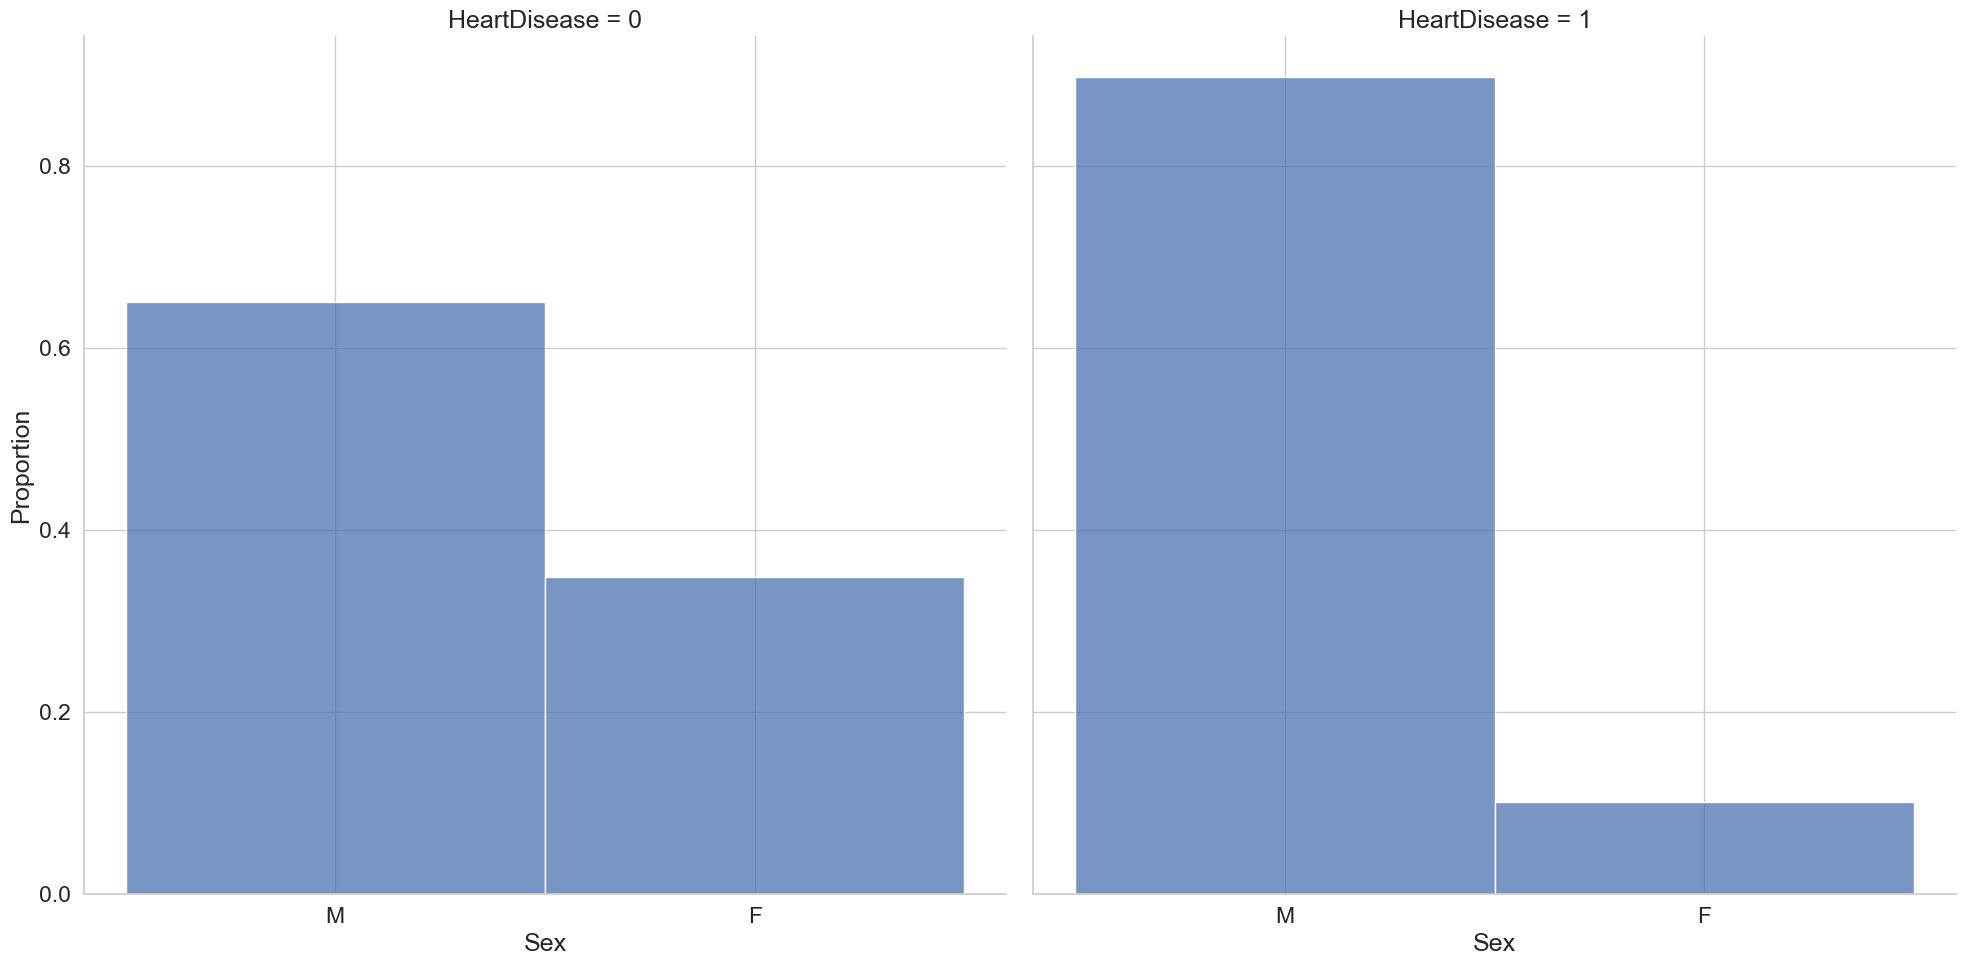

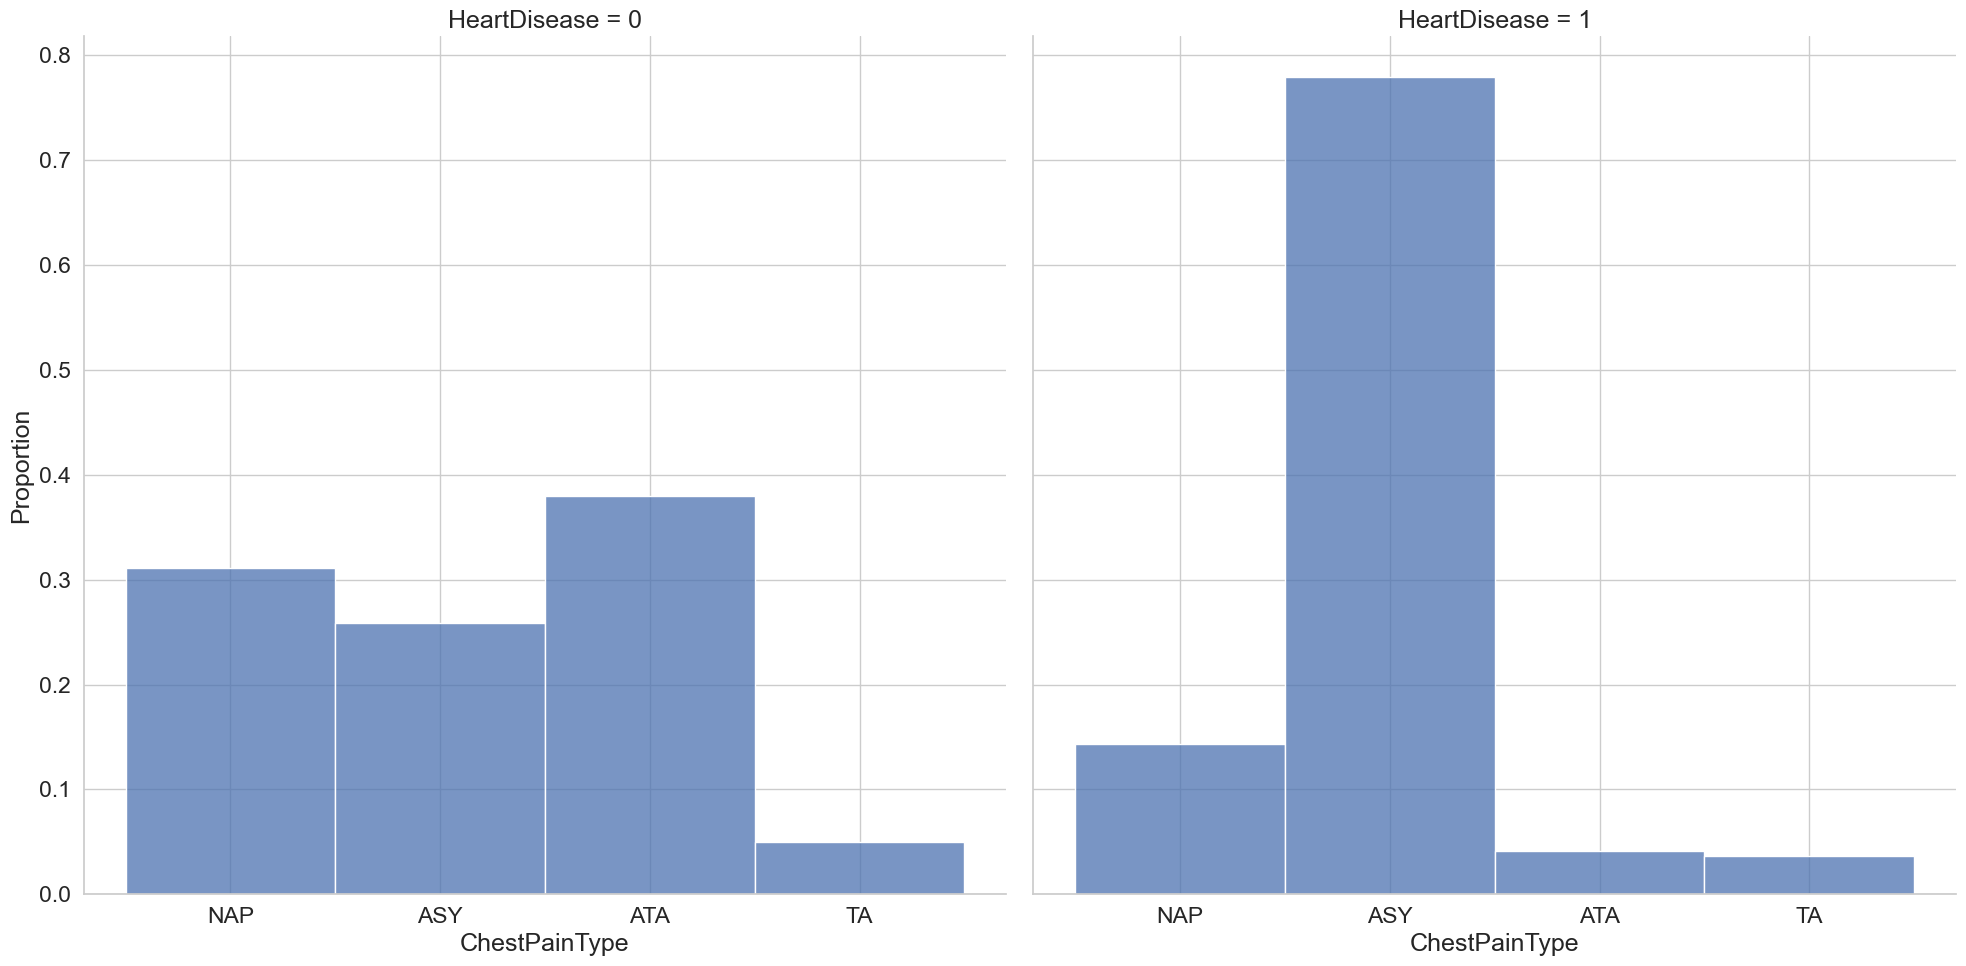

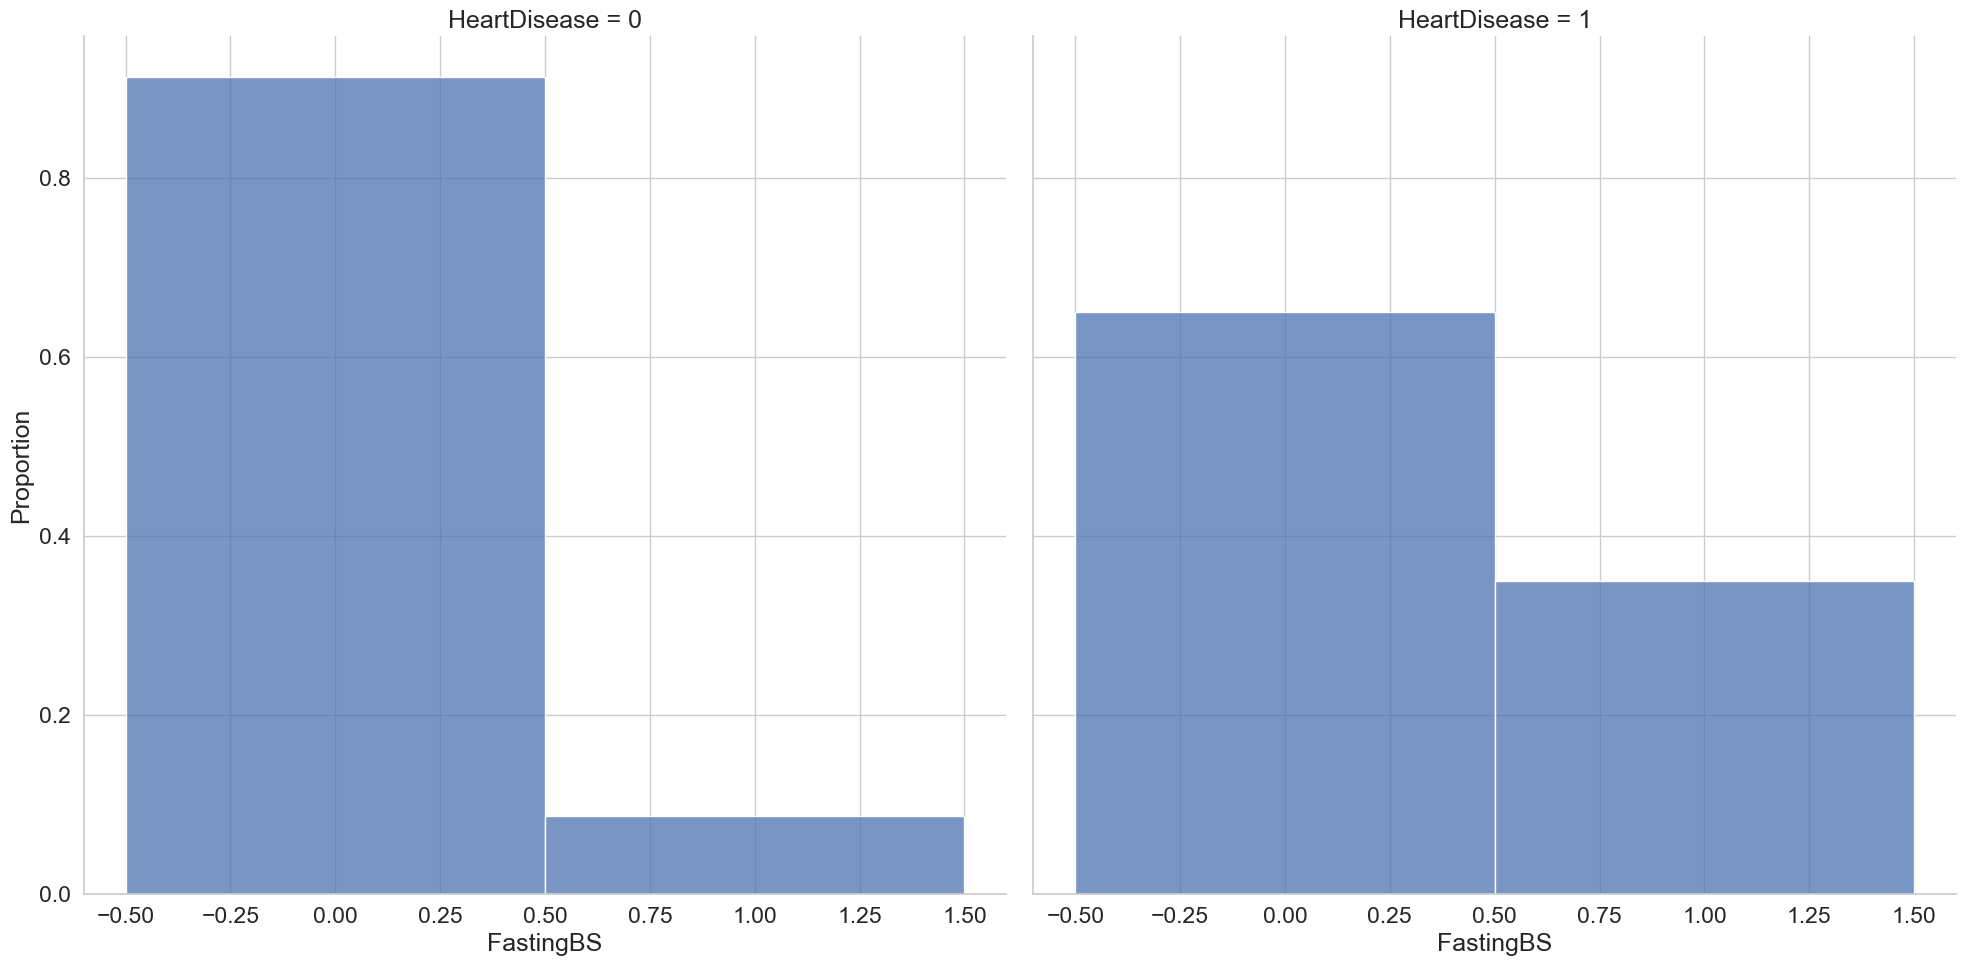

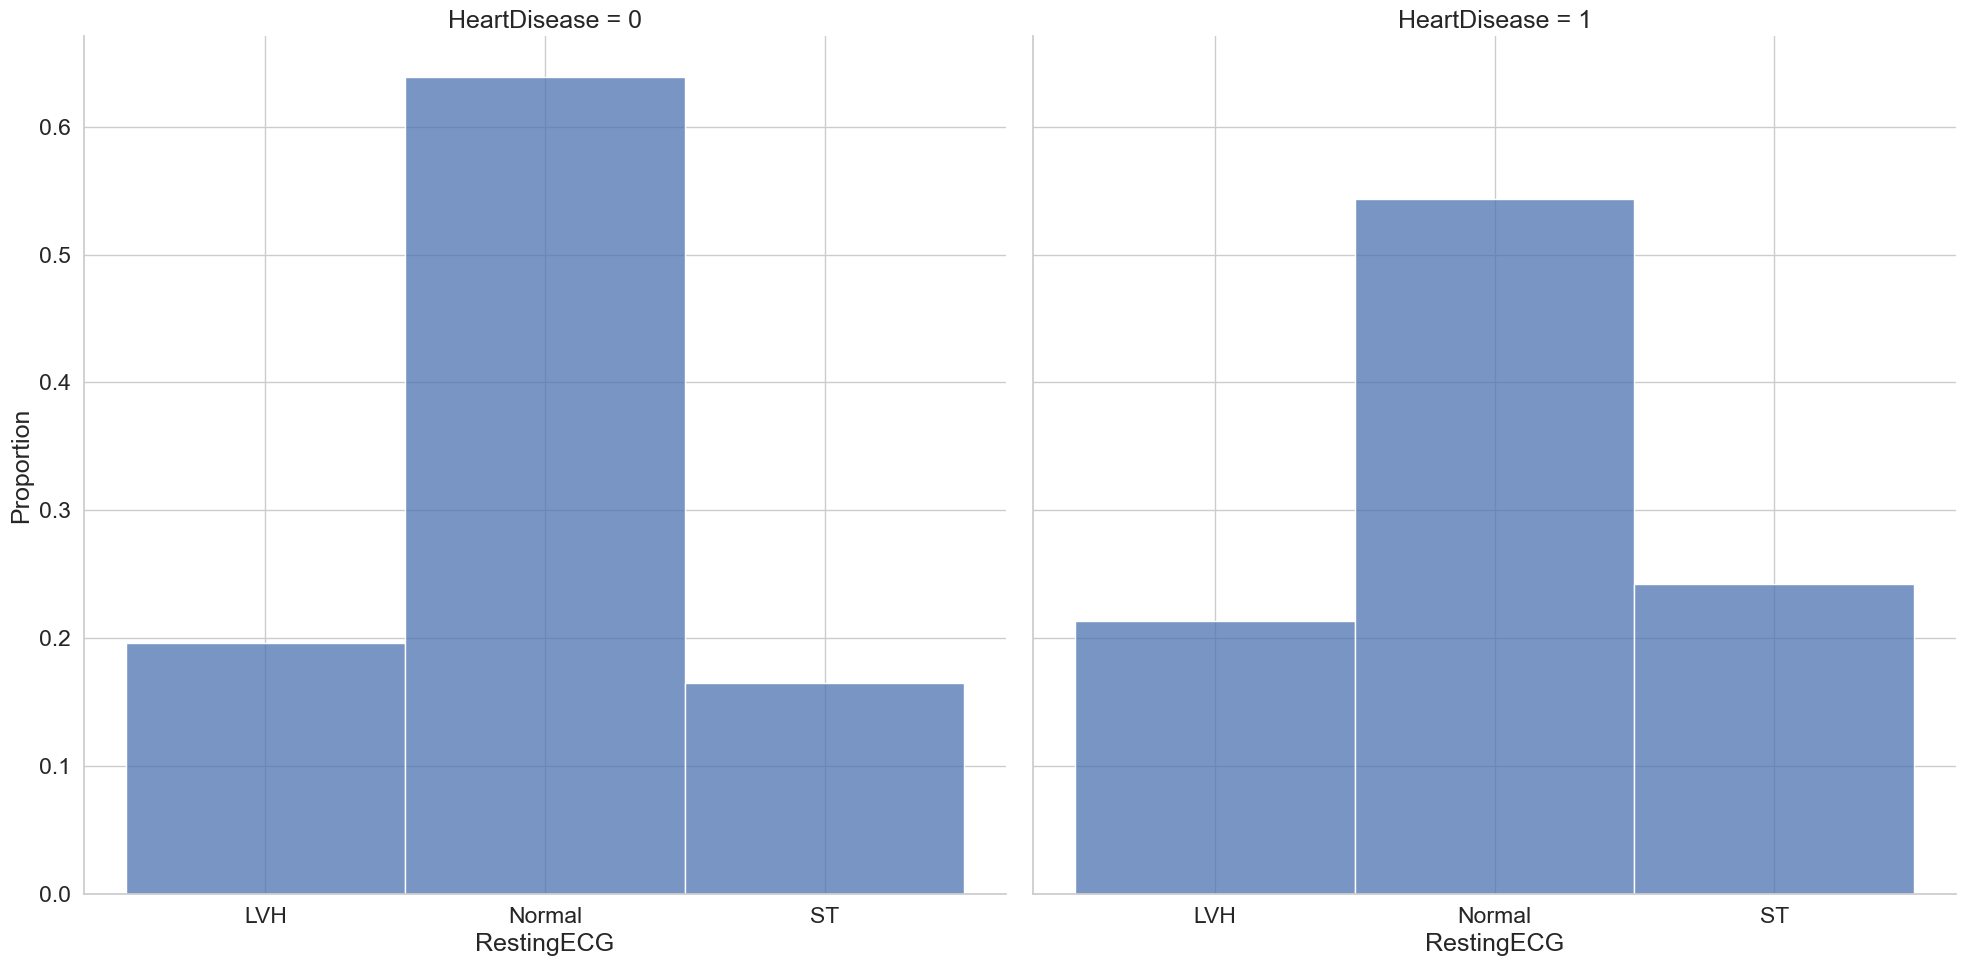

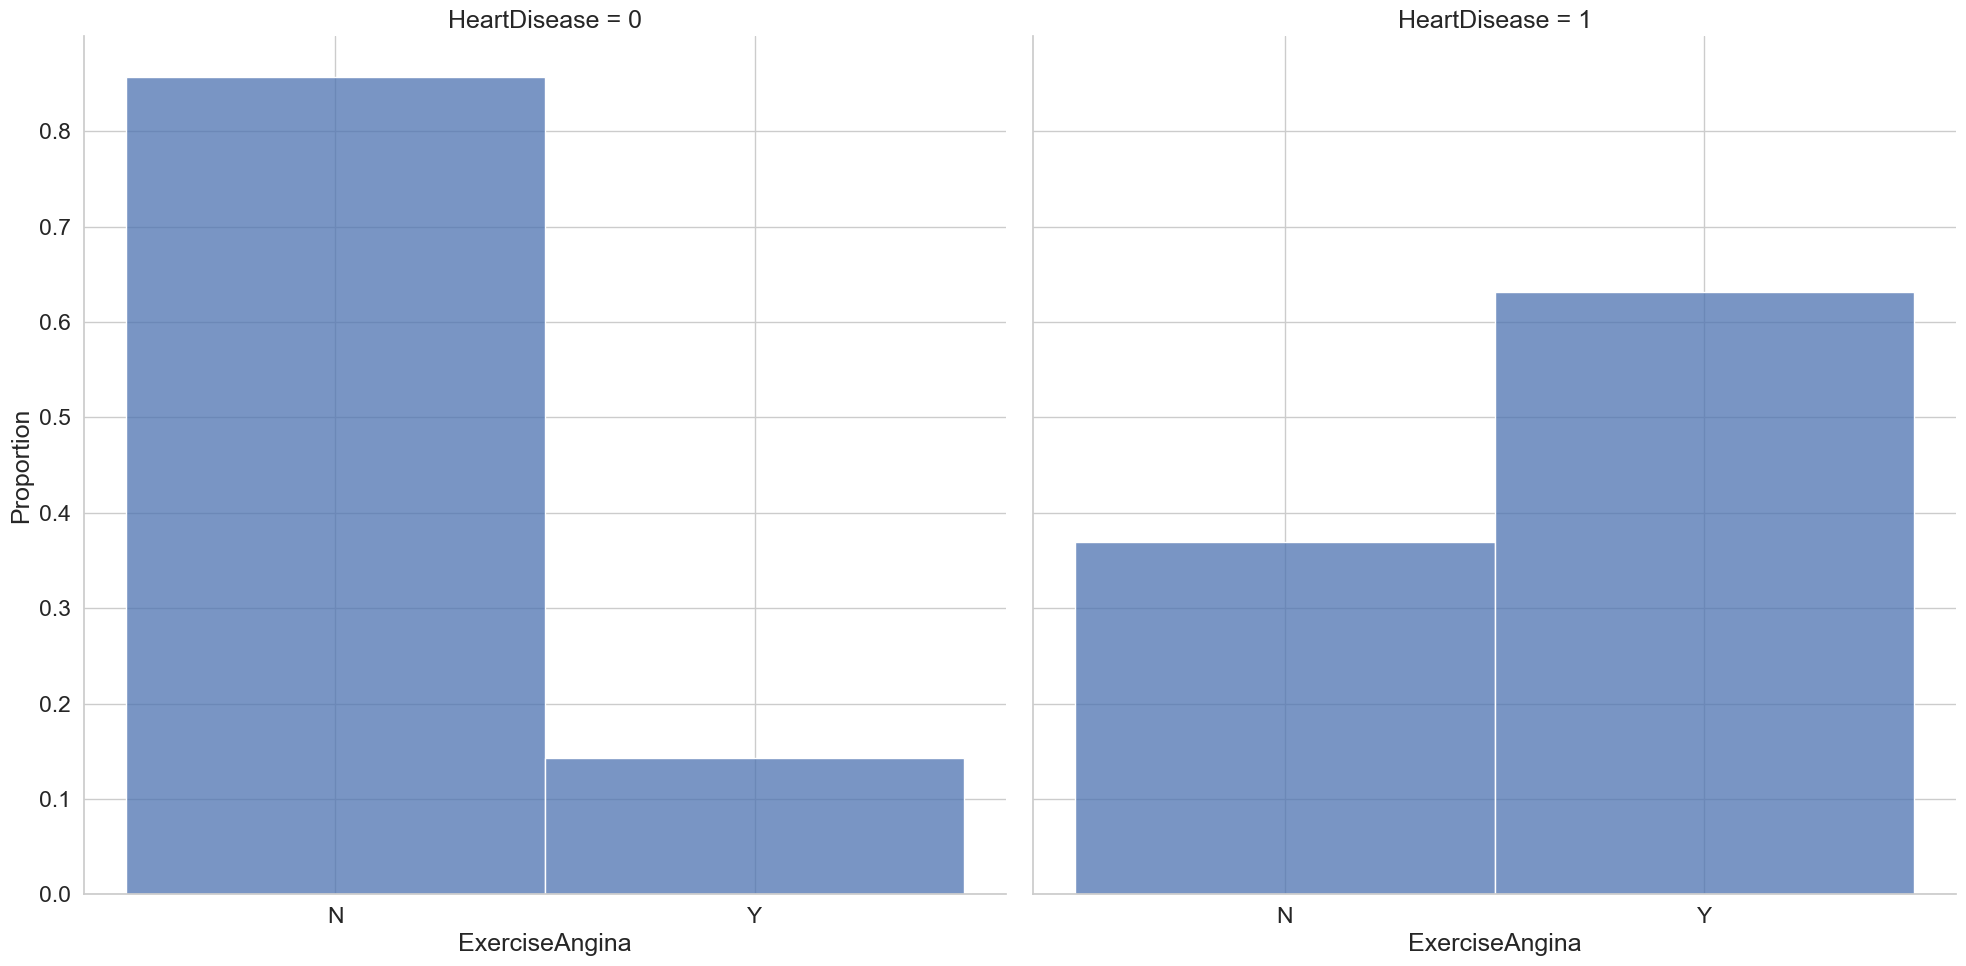

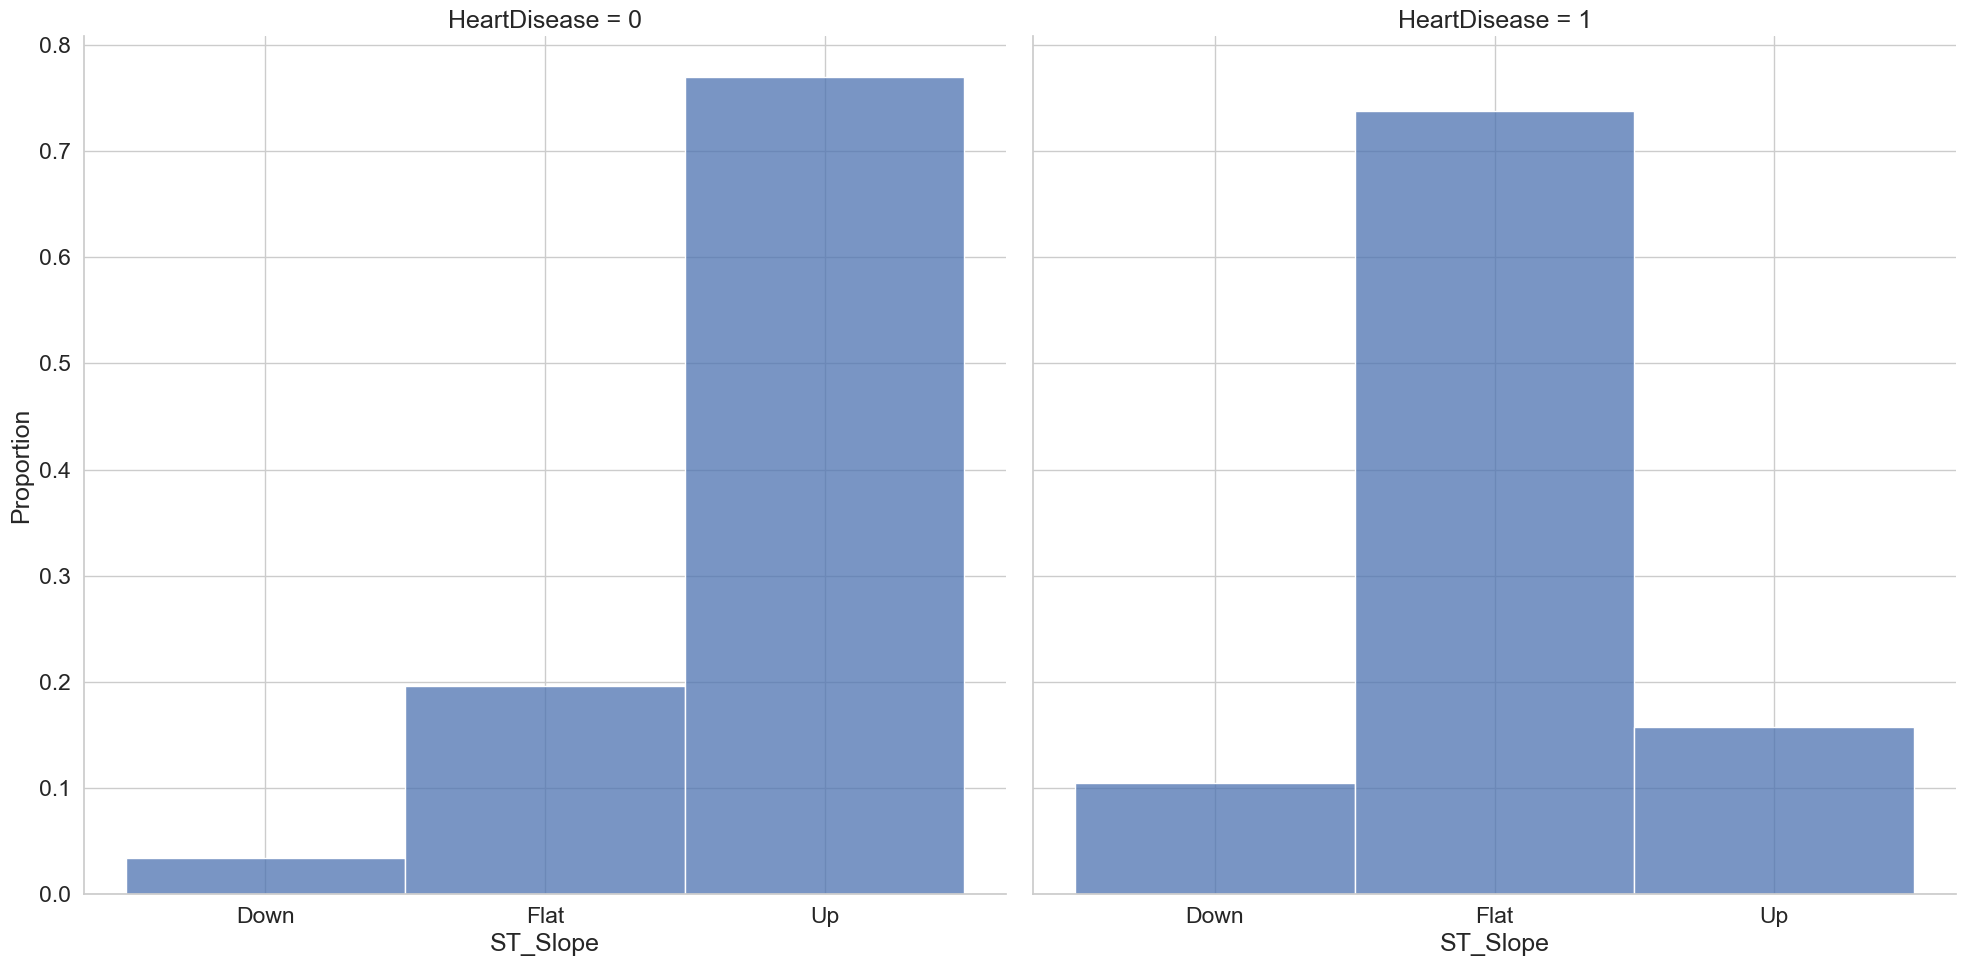

In [15]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
#sb.histplot(data=TrainData[cat[i]][ TrainData['HeartDisease'] == 0],multiple='stack')
#sb.histplot(data=TrainData[cat[i]][ TrainData['HeartDisease'] == 1],multiple='stack')
sb.set(style="whitegrid", font_scale=1.5)
for i in range(6):
    g = sb.FacetGrid(TrainData[[cat[i],'HeartDisease']], col="HeartDisease",height=10, aspect=1)
    g.map(sb.histplot, cat[i],stat='proportion')

Above shows the proportion of each variable when HeartDisease = 0 or 1 ( In other words, if there is presence of coronary heart disease), where the sum of all bars in the histgram is normalized to 0, to show the proportion of each categories.

- Sex:
  - There is a obvious unbalance in sex in this dataset, but still from proportion it suggests a higher risk of coronary heart disease in male.
- ChestPainType
  - Higher level of chestpain has a positive relationship with heart disease.
- FastingBS
  - Fasting blood sugar indicates a higher risk as well.
- RestingECG
  - Positive relation with presence of LVH and ST category.
- ExerciseAngina
  - Positive relation.
- ST_Slope
  - Most patients have Flat Slope, followed by the Down Slope. A Up Slope suggests negative relation with Heart Disease.

---

#### 1.3.2 Show relationship between Response and Numeric predictors
First let's try scatter and boxplots.

<Axes: xlabel='Age', ylabel='HeartDisease'>

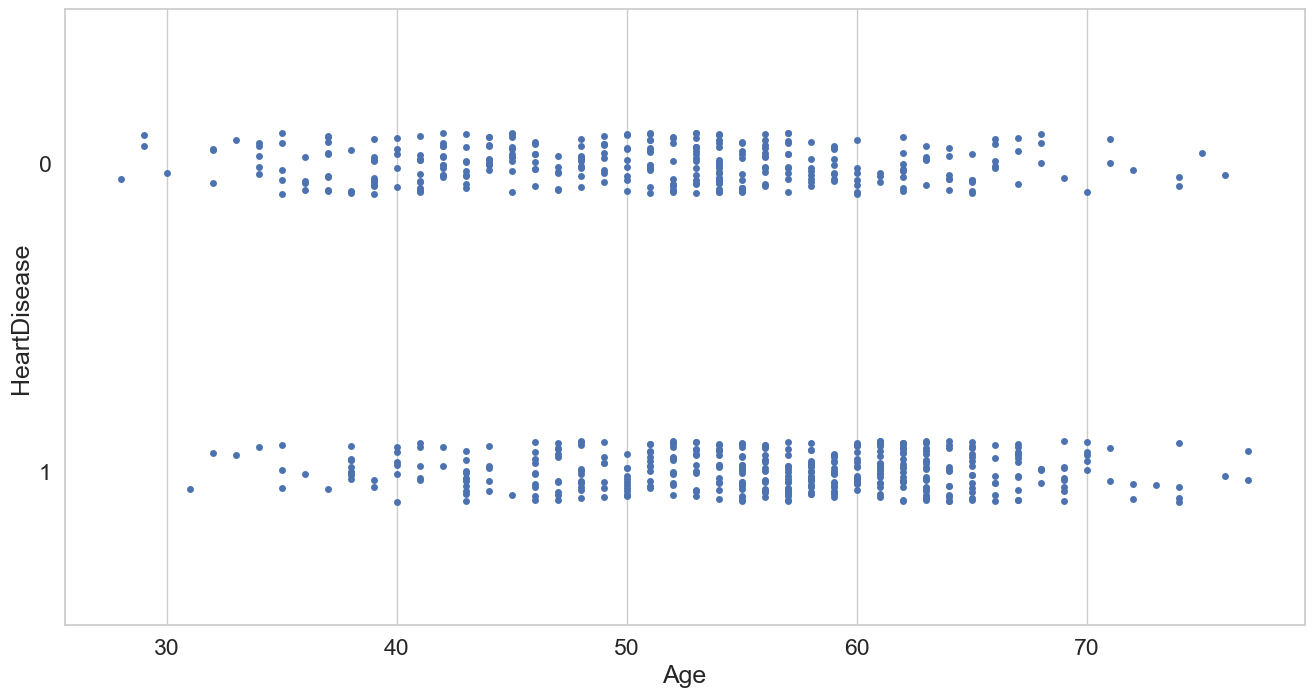

In [16]:
TrainData = heart_raw_dropped.loc[Xtrain.index]
f = plt.figure(figsize=(16, 8))
sb.stripplot(x = 'Age', y = 'HeartDisease', data = TrainData)

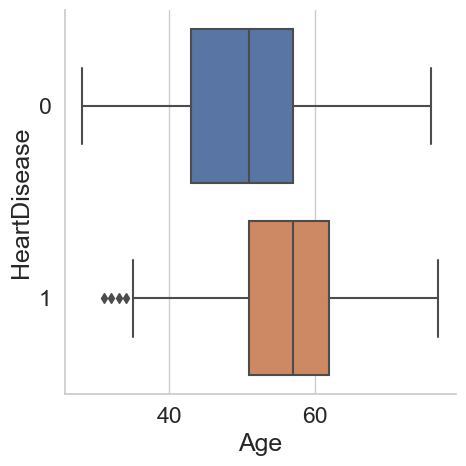

In [17]:
sb.catplot(data=TrainData, x="Age", y="HeartDisease", kind="box")

Boxplot is better when visualizing the data, so we picked boxplots for further plotting.

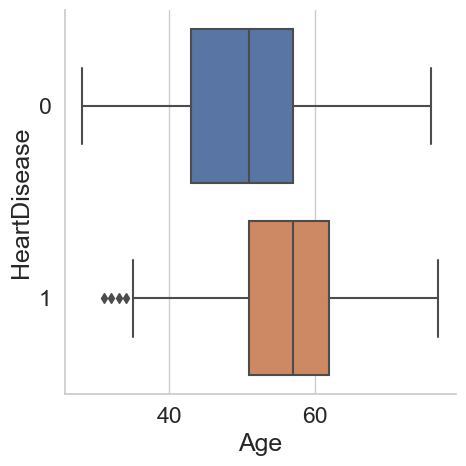

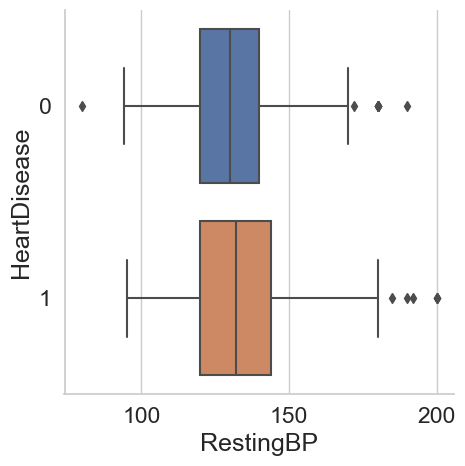

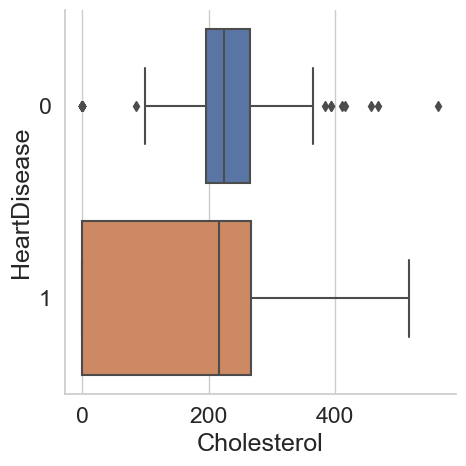

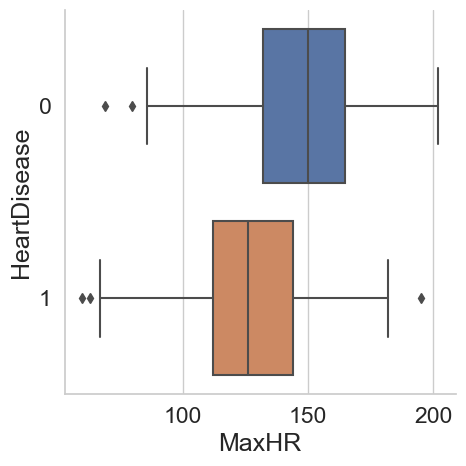

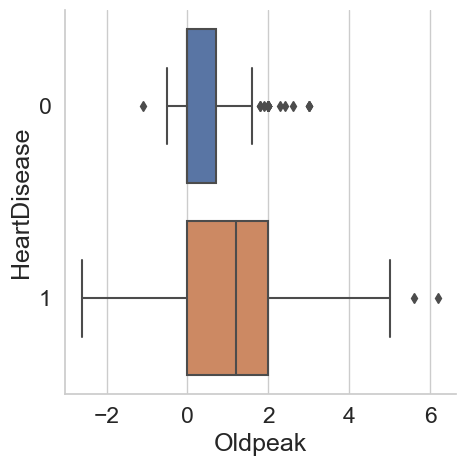

In [18]:
for i in range(5):
    sb.catplot(data=TrainData, x=numeric[i], y="HeartDisease", kind="box")
    #g = sb.FacetGrid(TrainData[[cat[i],'HeartDisease']], height=4, aspect=.5)
    #g.map(sb.stripplot,"HeartDisease",cat[i],order=['Yes','No'])

- Age
  - Overall positive relation with target. Higher Meadian and more concentrated for patients with heart disease.
- RestingBP
  - No significant difference with similar median.
- **Cholesterol**
  - Significant negative relationship, overall for positive patients, this value is **greatly skewed** and need further investigation.
- MaxHR
  - Negative relationship
- Oldpeak
  - Postive relationship. Positive cases are distributed wider, and higher median.
    > further explanation:ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms


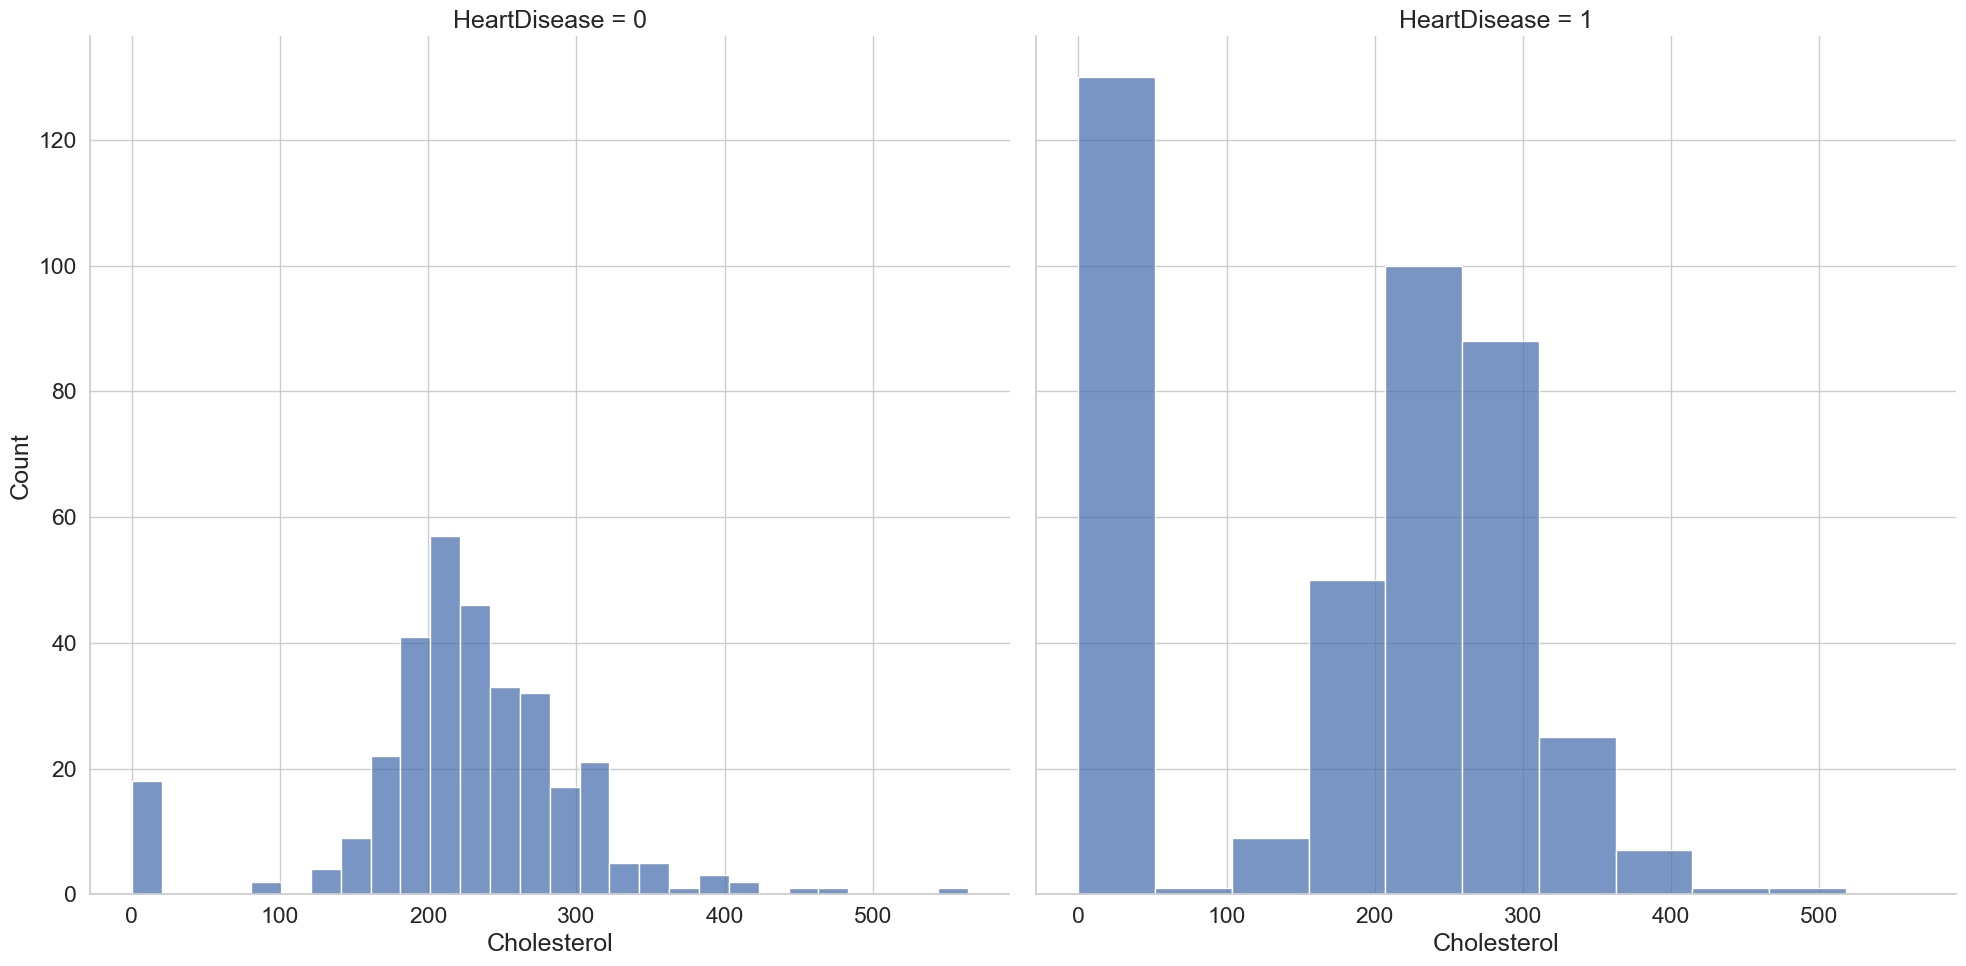

In [19]:
g = sb.FacetGrid(TrainData[['Cholesterol','HeartDisease']], col="HeartDisease",height=10, aspect=1)
g.map(sb.histplot, 'Cholesterol')

In [20]:
TrainData['Cholesterol'][TrainData['Cholesterol'] < 100].value_counts()

0     148
85      1
Name: Cholesterol, dtype: int64

**There are 137 entries with Cholesterol = 0 which is impossible so they should be missing values.**
A great proportion of entries with HeartDisease = 1 have Cholesterol = 0.


Currently it reflects a negative correlation with HeartDisease, but from medical knowledge it should be positive. Will test the correlation based on different imputer used.

#### 1.3.2.2 Test on Cholesterol

In [21]:
chole = TrainData[['Cholesterol','HeartDisease']]
chole = chole.astype({'HeartDisease':'int64'})
# Drop the entries.
data_drop = chole.drop(chole[chole['Cholesterol'] == 0].index)
print('Correlation After Dropping all 0s:')
print(data_drop.corr())
print()

# Filled with Median
medianImp = SimpleImputer(missing_values=0, strategy='median')
data_median = chole
data_median = data_median.reset_index()
target = pd.DataFrame(data_median['HeartDisease'])
data_median = medianImp.fit_transform(X=pd.DataFrame(data_median['Cholesterol']))
data_median = pd.concat([pd.DataFrame(data_median),target],axis=1)
print('Correlation After Filling with median:')
print(data_median.corr())

# Filled with Mean
meanImp = SimpleImputer(missing_values=0, strategy='mean')
data_median = chole
data_median = data_median.reset_index()
target = pd.DataFrame(data_median['HeartDisease'])
data_median = meanImp.fit_transform(X=pd.DataFrame(data_median['Cholesterol']))
data_median = pd.concat([pd.DataFrame(data_median),target],axis=1)
print('Correlation After Filling with mean:')
print(data_median.corr())

Correlation After Dropping all 0s:
              Cholesterol  HeartDisease
Cholesterol      1.000000      0.105674
HeartDisease     0.105674      1.000000

Correlation After Filling with median:
                     0  HeartDisease
0             1.000000      0.078496
HeartDisease  0.078496      1.000000
Correlation After Filling with mean:
                     0  HeartDisease
0             1.000000      0.095079
HeartDisease  0.095079      1.000000


**Results**:

As Filled with mean will boost its corrleation with HeartDisease, along with its weak correlation after dropping all 0 rows (Caused by most of the 0 rows have HeartDisease =1 I think), **I suggest not using cholesterol as a predictor.**

EDA Process finished.

---

## 2 Data Cleaning and Preprocessing
---
### 2.1 Imputing


Cholesterol should not use as a predictor, thus, no imputing will be done.No NAs in other predictors, only one 0 values, can be dropped.


---

### 2.2 Encoding Categorical Variables

> - #Sex: sex of the patient [M: Male, F: Female]
> - #ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
> - #FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
> - #RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation >    or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
> - #ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
> - #ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
> - #HeartDisease: output class [1: heart disease, 0: Normal]

- #Sex: Should be one-hot encoded
- #ChestPainType: Can be ordinal encoded.
- #FastingBS: Can be ordinal encoded.
- #RestingECG: Should be one-hot encoded
- #ExerciseAngina: Can be ordinal encoded.
- #ST_Slope: Should be one-hot encoded
- #HeartDisease: output class

**We will do transform later in pipelines**

### 2.3 Drop Outliers Row

As quantity of outliers is not so big, we can simply drop the rows they are in.

**\*`Cholesterol` will be dropped\***

---

First let's check numbers of outliers

In [22]:
TrainData = TrainData.drop('Cholesterol',axis=1)
TrainData

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
584,64,M,ASY,141,1,ST,116,Y,1.5,Flat,1
739,54,M,NAP,125,0,LVH,152,N,0.5,Down,0
637,43,M,ASY,115,0,Normal,181,N,1.2,Flat,0
862,65,F,NAP,155,0,Normal,148,N,0.8,Up,0
405,35,M,ASY,120,1,Normal,130,Y,1.2,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...
609,46,M,ASY,134,0,Normal,126,N,0.0,Flat,1
440,52,M,NAP,128,0,ST,180,N,3.0,Up,1
389,61,M,ASY,160,1,ST,145,N,1.0,Flat,1
743,52,M,ATA,134,0,Normal,158,N,0.8,Up,0


In [23]:
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
for v in numeric:
    q1 = TrainData[v].quantile(0.25)
    q3 = TrainData[v].quantile(0.75)
    IQR = q3 - q1
    count = len(TrainData[v].loc[ (TrainData[v] < q1 - 1.5* IQR) | (TrainData[v] > q3 + 1.5* IQR) ])
    print(f"{v} : {count}")

Age : 0
RestingBP : 21
MaxHR : 1
Oldpeak : 12


In [24]:
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
for v in numeric:
    q1 = TrainData[v].quantile(0.25)
    q3 = TrainData[v].quantile(0.75)
    IQR = q3 - q1
    TrainData = TrainData[ (TrainData[v] > q1 - 1.5* IQR) & (TrainData[v] < q3 + 1.5* IQR) ] # Filtered Data

TrainData

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
584,64,M,ASY,141,1,ST,116,Y,1.5,Flat,1
739,54,M,NAP,125,0,LVH,152,N,0.5,Down,0
637,43,M,ASY,115,0,Normal,181,N,1.2,Flat,0
862,65,F,NAP,155,0,Normal,148,N,0.8,Up,0
405,35,M,ASY,120,1,Normal,130,Y,1.2,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...
609,46,M,ASY,134,0,Normal,126,N,0.0,Flat,1
440,52,M,NAP,128,0,ST,180,N,3.0,Up,1
389,61,M,ASY,160,1,ST,145,N,1.0,Flat,1
743,52,M,ATA,134,0,Normal,158,N,0.8,Up,0


### 2.4 Scaling Numeric Variables


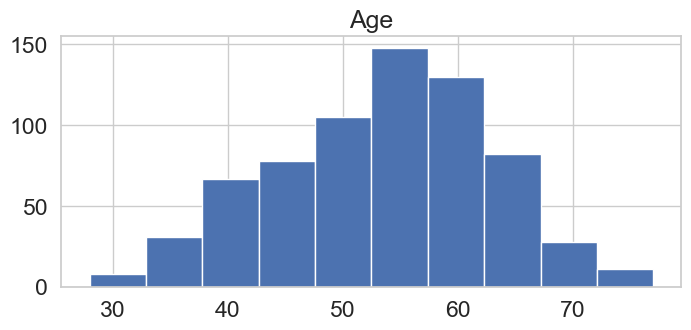

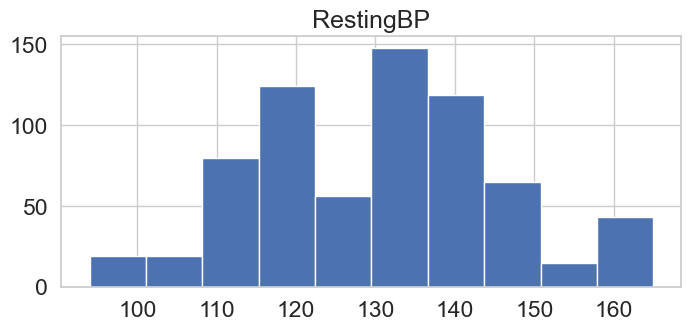

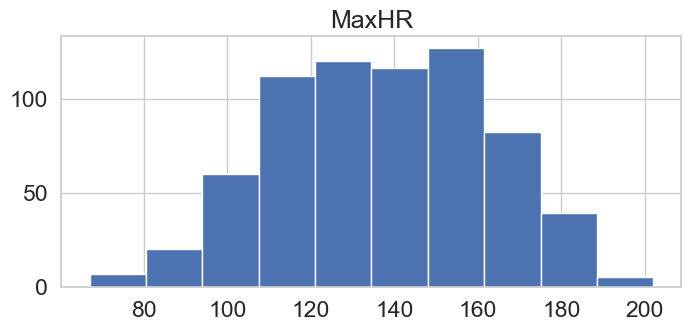

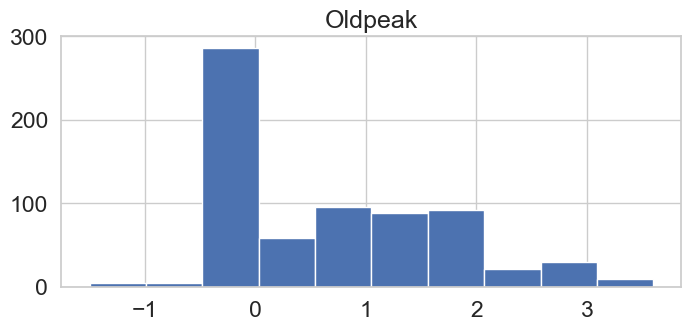

In [25]:
for v in range(4):
    plt.figure(figsize=(8, 15))
    plt.subplot(4,1,v+1)
    plt.title(numeric[v])
    plt.hist(TrainData[numeric[v]])

Distribution of Age, RestingBP, MaxHR are close to standard distributions and can be scaled by standardization.
However Oldpeak has a heavy tail. Besides it has negative values.

In [26]:
cat = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
Cat_OneHot = ['Sex','RestingECG','ST_Slope']
Cat_Ordinal = ['ChestPainType','FastingBS','ExerciseAngina']
numeric = ['Age','RestingBP','MaxHR','Oldpeak']
Num_Standardize = ['Age','RestingBP','MaxHR']  # Cholesterol is dropped from here on
Num_HeavyTail = ['Oldpeak']

---

Here is experiment on oldpeak

(array([  0.,   1.,   1.,   4.,   3.,   0., 311.,  33.,  26.,  76.,  40.,
         58.,  76.,   8.,  18.,  24.,   3.,   6.,   0.]),
 array([-2.        , -1.68421053, -1.36842105, -1.05263158, -0.73684211,
        -0.42105263, -0.10526316,  0.21052632,  0.52631579,  0.84210526,
         1.15789474,  1.47368421,  1.78947368,  2.10526316,  2.42105263,
         2.73684211,  3.05263158,  3.36842105,  3.68421053,  4.        ]),
 <BarContainer object of 19 artists>)

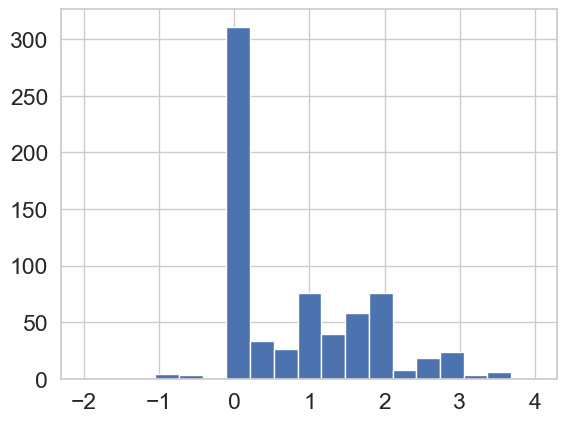

In [27]:
heavy = TrainData[Num_HeavyTail]
plt.hist(heavy,bins= np.linspace(-2,4,20))

(array([284.,   0.,   0.,  10.,  26.,  31.,  86., 105.,  96.,  39.]),
 array([-1.1241938 , -0.85896457, -0.59373534, -0.32850611, -0.06327689,
         0.20195234,  0.46718157,  0.7324108 ,  0.99764003,  1.26286926,
         1.52809848]),
 <BarContainer object of 10 artists>)

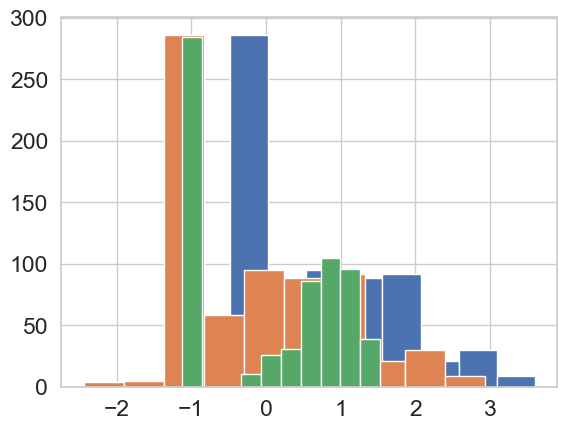

In [28]:
heavy = TrainData[Num_HeavyTail]
ss = StandardScaler()

plt.hist(heavy)
plt.hist(ss.fit_transform(heavy))
plt.hist(ss.fit_transform(heavy**0.3))

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0., 284.,
          0.,  10.,   0.,  15.,   0.,  11.,   0.,   8.]),
 array([-0.5       , -0.45263158, -0.40526316, -0.35789474, -0.31052632,
        -0.26315789, -0.21578947, -0.16842105, -0.12105263, -0.07368421,
        -0.02631579,  0.02105263,  0.06842105,  0.11578947,  0.16315789,
         0.21052632,  0.25789474,  0.30526316,  0.35263158,  0.4       ]),
 <BarContainer object of 19 artists>)

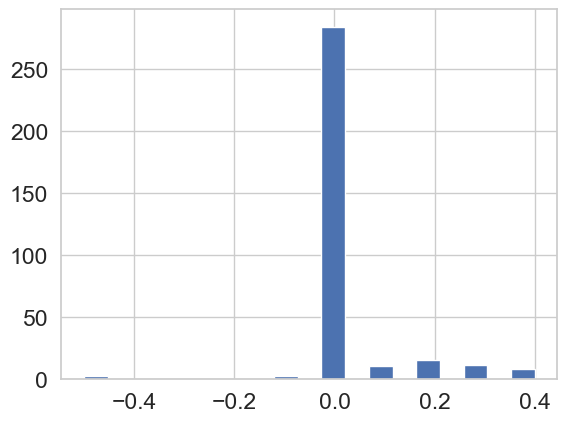

In [29]:
heavy = pd.DataFrame(TrainData[Num_HeavyTail])
center = heavy[ (heavy['Oldpeak'] < 0.4) | (heavy['Oldpeak'] > -0.5) ]
plt.hist(center,bins= np.linspace(-0.5,0.4,20))

**Conclusion: Most values are centralized at 0. Maybe no need to scale.**

In [30]:
transform_pipe = ColumnTransformer([
    ('num_standard',StandardScaler(),Num_Standardize),
    ('cat_onehot',OneHotEncoder(handle_unknown="ignore"),Cat_OneHot),
    ('cat_ordinal',OrdinalEncoder(),Cat_Ordinal)],remainder="passthrough")

#### Process and Write Data

In [31]:
heart_test = heart_raw_dropped.loc[Xtest.index]
TrainData.to_csv('train_raw.csv')
heart_test.to_csv('test_raw.csv')


In [32]:

heart_train_processed = pd.DataFrame(transform_pipe.fit_transform(TrainData))
heart_train_processed.columns = transform_pipe.get_feature_names_out()
heart_train_processed

,num_standard__Age,num_standard__RestingBP,num_standard__MaxHR,cat_onehot__Sex_F,cat_onehot__Sex_M,cat_onehot__RestingECG_LVH,cat_onehot__RestingECG_Normal,cat_onehot__RestingECG_ST,cat_onehot__ST_Slope_Down,cat_onehot__ST_Slope_Flat,cat_onehot__ST_Slope_Up,cat_ordinal__ChestPainType,cat_ordinal__FastingBS,cat_ordinal__ExerciseAngina,remainder__Oldpeak,remainder__HeartDisease
0,1.095951,0.716751,-0.822764,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.5,1.0
1,0.051031,-0.350330,0.606986,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.5,0.0
2,-1.098381,-1.017255,1.758728,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.2,0.0
3,1.200443,1.650446,0.448124,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.8,0.0
4,-1.934316,-0.683792,-0.266750,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,-0.784905,0.249903,-0.425611,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
684,-0.157953,-0.150252,1.719013,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,1.0
685,0.782475,1.983909,0.328979,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
686,-0.157953,0.249903,0.845277,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.8,0.0


In [33]:
heart_test_processed = pd.DataFrame(transform_pipe.transform(heart_test)) 
# When pipeline is trained on train set, it should not fit test set.
# Just transform.
heart_test_processed.columns = transform_pipe.get_feature_names_out()
heart_test_processed

,num_standard__Age,num_standard__RestingBP,num_standard__MaxHR,cat_onehot__Sex_F,cat_onehot__Sex_M,cat_onehot__RestingECG_LVH,cat_onehot__RestingECG_Normal,cat_onehot__RestingECG_ST,cat_onehot__ST_Slope_Down,cat_onehot__ST_Slope_Flat,cat_onehot__ST_Slope_Up,cat_ordinal__ChestPainType,cat_ordinal__FastingBS,cat_ordinal__ExerciseAngina,remainder__Oldpeak,remainder__HeartDisease
0,0.886967,0.583366,-0.663903,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0
1,0.886967,-0.016867,-1.577354,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.2,1.0
2,1.095951,0.916828,-0.584473,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,-1.202873,-0.683792,0.726131,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.098381,1.316983,1.361576,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1.513919,3.317759,0.527555,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.6,1.0
180,0.677983,-0.683792,-0.147605,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0
181,-1.307365,-0.350330,0.289263,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
182,-0.471429,1.983909,0.765847,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0


In [34]:
heart_train_processed.to_csv('train_processed.csv')
heart_test_processed.to_csv('test_processed.csv')


### 3 CREATING MODELS



With the EDA and cleaning of data done, we shall now move on to creating classification models to help predict the likelihood of heart disease with the predictor variables that we had mentioned before.

---------------------------------

***ATTEMPT 1 USING A NORMAL BINARY CLASSIFICATION TREE***

In [35]:
heart_train_processed.describe()

,num_standard__Age,num_standard__RestingBP,num_standard__MaxHR,cat_onehot__Sex_F,cat_onehot__Sex_M,cat_onehot__RestingECG_LVH,cat_onehot__RestingECG_Normal,cat_onehot__RestingECG_ST,cat_onehot__ST_Slope_Down,cat_onehot__ST_Slope_Flat,cat_onehot__ST_Slope_Up,cat_ordinal__ChestPainType,cat_ordinal__FastingBS,cat_ordinal__ExerciseAngina,remainder__Oldpeak,remainder__HeartDisease
count,6.880000e+02,6.880000e+02,6.880000e+02,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,2.762648e-16,3.356488e-17,2.478637e-16,0.206395,0.793605,0.206395,0.591570,0.202035,0.062500,0.501453,0.436047,0.768895,0.234012,0.401163,0.814244,0.549419
std,1.000728e+00,1.000728e+00,1.000728e+00,0.405012,0.405012,0.405012,0.491901,0.401810,0.242238,0.500362,0.496254,0.937846,0.423688,0.490490,0.950921,0.497914
min,-2.665760e+00,-2.417798e+00,-2.768812e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,0.000000
25%,-6.804128e-01,-6.837922e-01,-7.036183e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.103096e-02,-1.686700e-02,5.097178e-02,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
75%,7.824747e-01,6.500582e-01,7.658466e-01,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.500000,1.000000
max,2.454346e+00,2.317371e+00,2.592749e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,3.600000,1.000000


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8648255813953488
TPR Train 			: 0.8835978835978836
TNR Train 			: 0.8419354838709677

FPR Train 			: 0.15806451612903225
FNR Train 			: 0.1164021164021164

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8532608695652174
TPR Train 			: 0.8835978835978836
TNR Train 			: 0.8419354838709677

FPR Train 			: 0.15806451612903225
FNR Train 			: 0.1164021164021164


<Axes: >

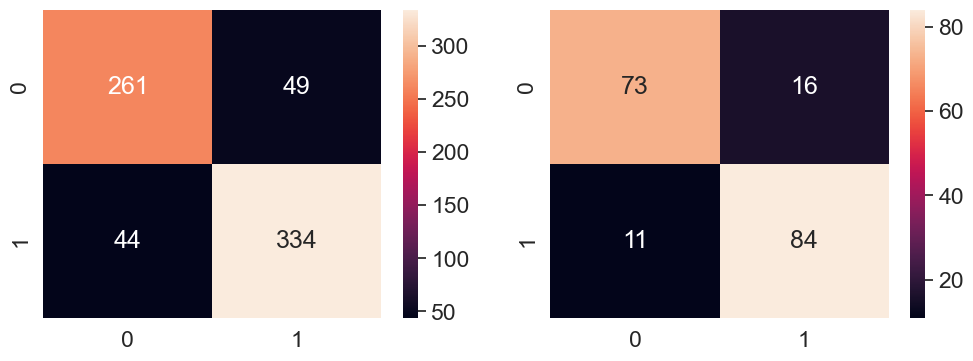

In [36]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
predictors = ["num_standard__Age", "num_standard__MaxHR", "cat_ordinal__ChestPainType", "cat_ordinal__ExerciseAngina", "cat_onehot__ST_Slope_Flat", "cat_ordinal__ChestPainType","remainder__Oldpeak"]

y_train = pd.DataFrame(heart_train_processed['remainder__HeartDisease'])
X_train = pd.DataFrame(heart_train_processed[predictors])
y_test = pd.DataFrame(heart_test_processed['remainder__HeartDisease'])
X_test = pd.DataFrame(heart_test_processed[predictors]) 

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

[Text(0.5267857142857143, 0.9, 'cat_onehot__ST_Slope_Flat <= 0.5\ngini = 0.495\nsamples = 688\nvalue = [310, 378]\nclass = Heart Disease'),
 Text(0.2857142857142857, 0.7, 'cat_ordinal__ChestPainType <= 0.5\ngini = 0.398\nsamples = 343\nvalue = [249, 94]\nclass = No Heart Disease'),
 Text(0.14285714285714285, 0.5, 'remainder__Oldpeak <= 0.45\ngini = 0.492\nsamples = 131\nvalue = [57, 74]\nclass = Heart Disease'),
 Text(0.07142857142857142, 0.3, 'remainder__Oldpeak <= -0.35\ngini = 0.453\nsamples = 72\nvalue = [47, 25]\nclass = No Heart Disease'),
 Text(0.03571428571428571, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = Heart Disease'),
 Text(0.10714285714285714, 0.1, 'gini = 0.427\nsamples = 68\nvalue = [47, 21]\nclass = No Heart Disease'),
 Text(0.21428571428571427, 0.3, 'num_standard__MaxHR <= -1.597\ngini = 0.282\nsamples = 59\nvalue = [10, 49]\nclass = Heart Disease'),
 Text(0.17857142857142858, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = No Heart Disease'),
 Te

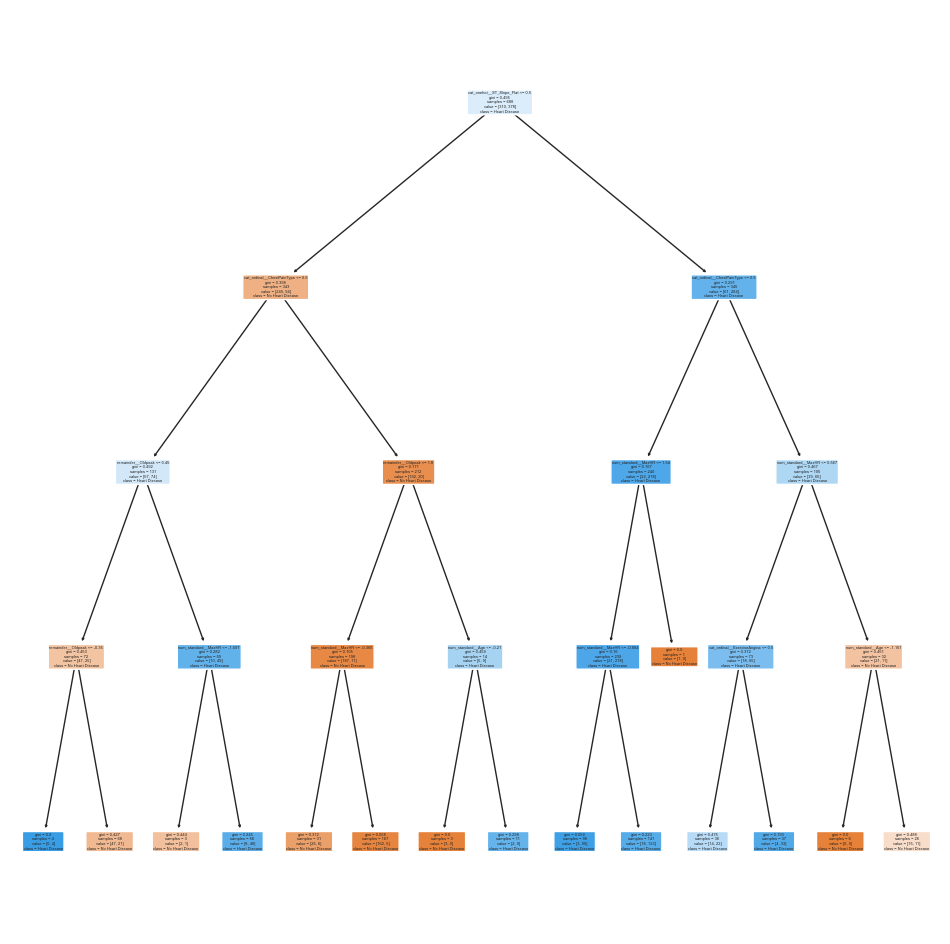

In [37]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(12,12))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns), 
          class_names=["No Heart Disease", "Heart Disease"])

Our first attempt at creating a classification model using a normal classification tree has yielded a tree with an classification accuracy of ~0.82 and a false positive rate of ~0.15. Although this is quite a respectable score, we will like to try and make our classification model even more accurate

**ATTEMPT 2 USING RANDOM FOREST CLASSIFICATION TREE METHOD WITH UPSCALING OF FEMALE DATA**

Earlier we mentioned that the data was heavily skewed towards males, I now shall try to upscale the female data and implement a random forest classification method to see if it will yield any improvements to our classification accuracy.

In [38]:
heart_train_processed['cat_onehot__Sex_M'].value_counts()


1.0    546
0.0    142
Name: cat_onehot__Sex_M, dtype: int64

**UPSCALING DATA**

As seen from above, the males in the train data is about a three times difference as compared to female. We shall try to upsample female data to make them equal.

In [39]:
# Upsample Bad to match Good for train data
from sklearn.utils import resample

heart_train_processed_male = heart_train_processed[heart_train_processed.cat_onehot__Sex_M == 1.0]
heart_train_processed_female = heart_train_processed[heart_train_processed.cat_onehot__Sex_M == 0.0]
# Upsample the Bad samples
heart_train_processed_female_up = resample(heart_train_processed_female, 
                        replace=True,                     # sample with replacement
                        n_samples=heart_train_processed_male.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
heart_train_processed_up = pd.concat([heart_train_processed_male, heart_train_processed_female_up])
 
# Check the ratio of the classes
heart_train_processed_up['cat_onehot__Sex_M'].value_counts()
 

1.0    546
0.0    546
Name: cat_onehot__Sex_M, dtype: int64

In [40]:
# Upsample Bad to match Good for test data
from sklearn.utils import resample

heart_test_processed_male = heart_test_processed[heart_test_processed.cat_onehot__Sex_M == 1.0]
heart_test_processed_female = heart_test_processed[heart_test_processed.cat_onehot__Sex_M == 0.0]
# Upsample the Bad samples
heart_test_processed_female_up = resample(heart_test_processed_female, 
                        replace=True,                     # sample with replacement
                        n_samples=heart_test_processed_male.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
heart_test_processed_up = pd.concat([heart_test_processed_male, heart_test_processed_female_up])
 
# Check the ratio of the classes
heart_test_processed_up['cat_onehot__Sex_M'].value_counts()

1.0    145
0.0    145
Name: cat_onehot__Sex_M, dtype: int64

**USING RANDOM FOREST CLASSIFICATION**

After upsampling the female data for both train and test data we will now go ahead and apply random forest classification.

In [41]:
# Extract Response and Predictors
predictors = ["num_standard__Age", "num_standard__MaxHR", "cat_ordinal__ChestPainType", "cat_ordinal__ExerciseAngina", "cat_onehot__ST_Slope_Flat", "cat_ordinal__ChestPainType","remainder__Oldpeak"]

y_train = pd.DataFrame(heart_train_processed_up['remainder__HeartDisease'])
X_train = pd.DataFrame(heart_train_processed_up[predictors]) 
y_test = pd.DataFrame(heart_test_processed_up['remainder__HeartDisease'])
X_test = pd.DataFrame(heart_test_processed_up[predictors]) 

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.remainder__HeartDisease.ravel())

RandomForestClassifier(max_depth=4)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8470695970695971
TPR Train 			: 0.8382352941176471
TNR Train 			: 0.8896103896103896

FPR Train 			: 0.11038961038961038
FNR Train 			: 0.16176470588235295



<Axes: >

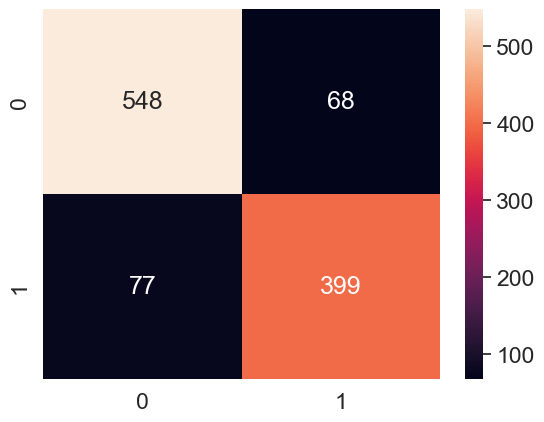

In [42]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print classification accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))
print()

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8206896551724138
TPR Test 			: 0.8382352941176471
TNR Test 			: 0.8896103896103896

FPR Test 			: 0.11038961038961038
FNR Test 			: 0.16176470588235295


<Axes: >

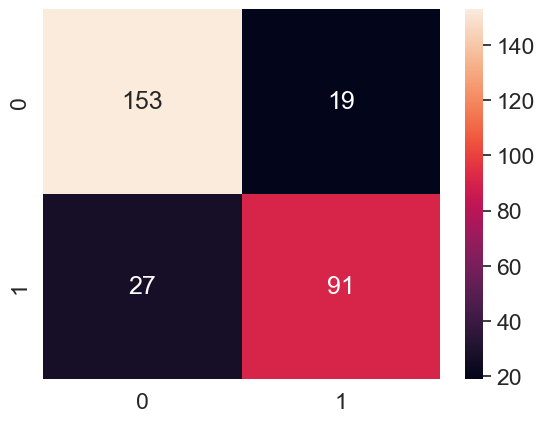

In [43]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)


# Print the Accuracy Measures from the Confusion Matrix
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Test \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Test \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Test \t\t\t:", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

It seems that random forest model is doing slightly better than our original model with a slightly higher classification score and lower false positive and false negative rate.

ATTEMPT 3: USING RANDOM FOREST CLASSIFICATION TREE METHOD ON MALE AND FEMALE SEPARATELY


In [44]:
male_train = heart_train_processed[heart_train_processed['cat_onehot__Sex_F'] == 0]
male_test = heart_test_processed[heart_test_processed['cat_onehot__Sex_F'] == 0]

In [45]:
female_train = heart_train_processed[heart_train_processed['cat_onehot__Sex_F'] == 1]
female_test = heart_test_processed[heart_test_processed['cat_onehot__Sex_F'] == 1]

RANDOM FOREST ON MALE

In [46]:
# Extract Response and Predictors for Male
predictors = ["num_standard__Age", "num_standard__MaxHR", "cat_ordinal__ChestPainType", "cat_ordinal__ExerciseAngina", "cat_onehot__ST_Slope_Flat", "cat_ordinal__ChestPainType","remainder__Oldpeak"]

y_train = pd.DataFrame(male_train['remainder__HeartDisease'])
X_train = pd.DataFrame(male_train[predictors]) 
y_test = pd.DataFrame(male_test['remainder__HeartDisease'])
X_test = pd.DataFrame(male_test[predictors]) 

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
Maleforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
Maleforest.fit(X_train, y_train.remainder__HeartDisease.ravel())

RandomForestClassifier(max_depth=4)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8772893772893773
TPR Train 			: 0.9505813953488372
TNR Train 			: 0.806930693069307

FPR Train 			: 0.19306930693069307
FNR Train 			: 0.04941860465116279



<Axes: >

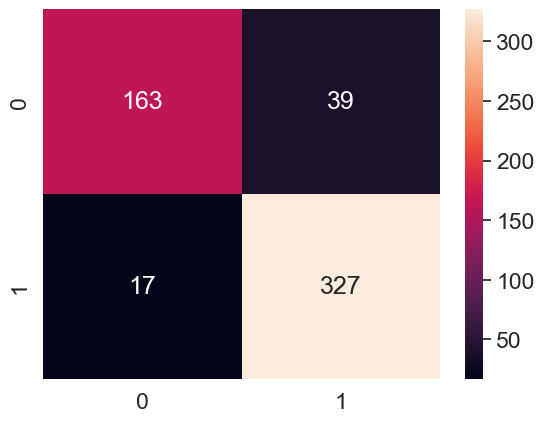

In [47]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = Maleforest.predict(X_train)

# Print classification accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))
print()

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8620689655172413
TPR Test 			: 0.9505813953488372
TNR Test 			: 0.806930693069307

FPR Test 			: 0.19306930693069307
FNR Test 			: 0.04941860465116279


<Axes: >

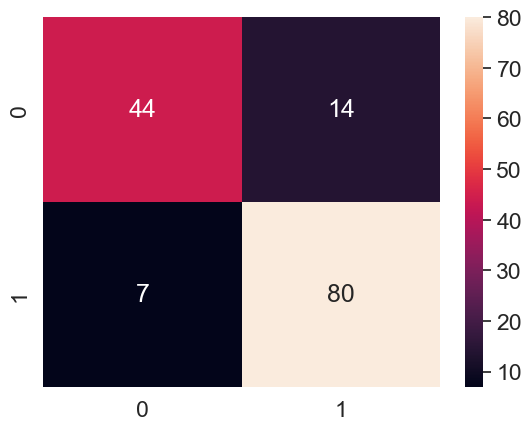

In [48]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = Maleforest.predict(X_test)


# Print the Accuracy Measures from the Confusion Matrix
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Test \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Test \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Test \t\t\t:", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

RANDOM FOREST ON FEMALE

In [49]:
# Extract Response and Predictors for Female
predictors = ["num_standard__Age", "num_standard__MaxHR", "cat_ordinal__ChestPainType", "cat_ordinal__ExerciseAngina", "cat_onehot__ST_Slope_Flat", "cat_ordinal__ChestPainType","remainder__Oldpeak"]

y_train = pd.DataFrame(female_train['remainder__HeartDisease'])
X_train = pd.DataFrame(female_train[predictors]) 
y_test = pd.DataFrame(female_test['remainder__HeartDisease'])
X_test = pd.DataFrame(female_test[predictors]) 

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
Femaleforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
Femaleforest.fit(X_train, y_train.remainder__HeartDisease.ravel())

RandomForestClassifier(max_depth=4)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8169014084507042
TPR Train 			: 0.7941176470588235
TNR Train 			: 0.9629629629629629

FPR Train 			: 0.037037037037037035
FNR Train 			: 0.20588235294117646



<Axes: >

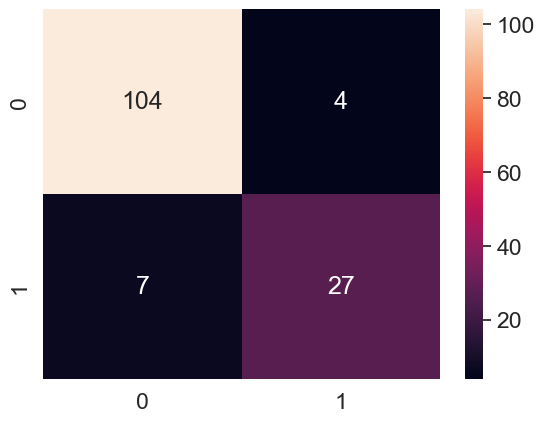

In [50]:
# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = Femaleforest.predict(X_train)

# Print classification accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))
print()

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8205128205128205
TPR Test 			: 0.7941176470588235
TNR Test 			: 0.9629629629629629

FPR Test 			: 0.037037037037037035
FNR Test 			: 0.20588235294117646


<Axes: >

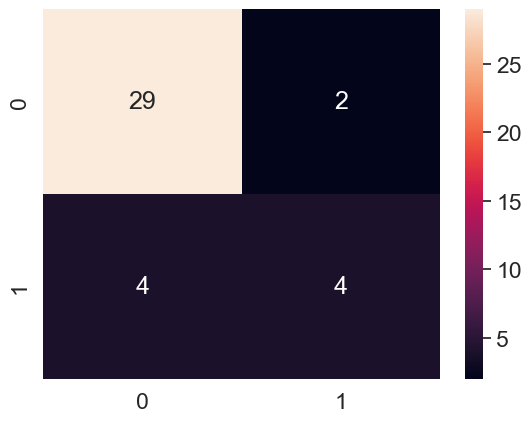

In [51]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = Femaleforest.predict(X_test)


# Print the Accuracy Measures from the Confusion Matrix
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Test \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Test \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Test \t\t\t:", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### ATTEMPT 4 USING SUPPORT VECTOR MODEL ###

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8648255813953488
TPR Train 			: 0.8544973544973545
TNR Train 			: 0.7806451612903226

FPR Train 			: 0.21935483870967742
FNR Train 			: 0.1455026455026455



<Axes: >

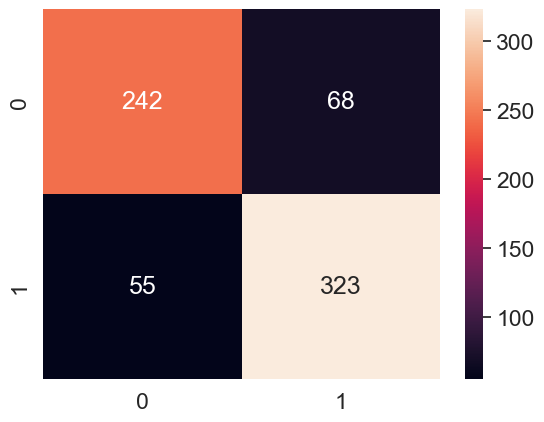

In [68]:
# Extract Response and Predictors for Female
predictors = ["num_standard__Age", "num_standard__MaxHR", "cat_ordinal__ChestPainType", "cat_ordinal__ExerciseAngina", "cat_onehot__ST_Slope_Flat", "cat_ordinal__ChestPainType","remainder__Oldpeak"]

y_train = pd.DataFrame(heart_train_processed['remainder__HeartDisease'])
X_train = pd.DataFrame(heart_train_processed[predictors]) 
y_test = pd.DataFrame(heart_test_processed['remainder__HeartDisease'])
X_test = pd.DataFrame(heart_test_processed[predictors]) 
y_train=y_train.values.ravel()
y_test=y_test.values.ravel()
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

# Import confusion_matrix from Scikit-Learn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = clf.predict(X_train)

# Print classification accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train \t\t\t:", (fnTrain/(tpTrain + fnTrain)))
print()

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8532608695652174
TPR Test 			: 0.8544973544973545
TNR Test 			: 0.7806451612903226

FPR Test 			: 0.21935483870967742
FNR Test 			: 0.1455026455026455


<Axes: >

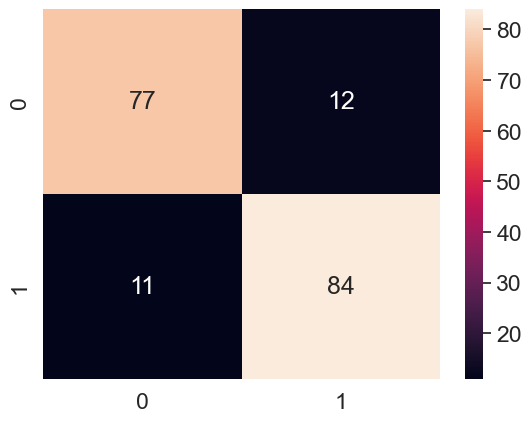

In [70]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = clf.predict(X_test)
# Print the Accuracy Measures from the Confusion Matrix
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test \t\t\t:", (tpTrain/(tpTrain + fnTrain)))
print("TNR Test \t\t\t:", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Test \t\t\t:", (fpTrain/(tnTrain + fpTrain)))
print("FNR Test \t\t\t:", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})